## Downloading the data and preprocessing it.

In [ ]:
!pip install -q tensorflow==2.15.0 tensorflow-hub==0.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 459 ms, sys: 117 ms, total: 577 ms
Wall time: 610 ms


(180040, 30212, 30135)

In [ ]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# Getting the sentences and characters
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

### 4. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), TensorShape([180040, 15]))

In [ ]:
# Re-building the Model 5

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)


# 2. Char inputs
char_inputs = layers.Input(shape= [], dtype="string", name="char_inputs")
char_embeddings = tf_hub_embedding_layer(char_inputs)
exp_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(exp_layer)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)



# Summary of the model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]',        
  (KerasLayer)                                            24         'char_inputs[0][0]']         
                                                                                                  
 lambda_1 (Lambda)           (None, 1, 512)               0         ['universal_sentence_enc

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
test_pos_char_token_dataset, test_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

`tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.

`tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.


In [ ]:
# Creating the callbacks
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath ,
                                                               save_weights_only = True ,
                                                               save_best_only = True  ,
                                                               save_freq = 'epoch' ,
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' ,
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

Now while compile and fit the data on 100% of the training data.

> Note: You can lower the `min_delta` or set it as default  in the EarlyStopping callback while training the model. To speed up the experiments I have used 0.8.

In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]',        
  (KerasLayer)                                            24         'char_inputs[0][0]']         
                                                                                                  
 lambda_1 (Lambda)           (None, 1, 512)               0         ['universal_sentence_enc

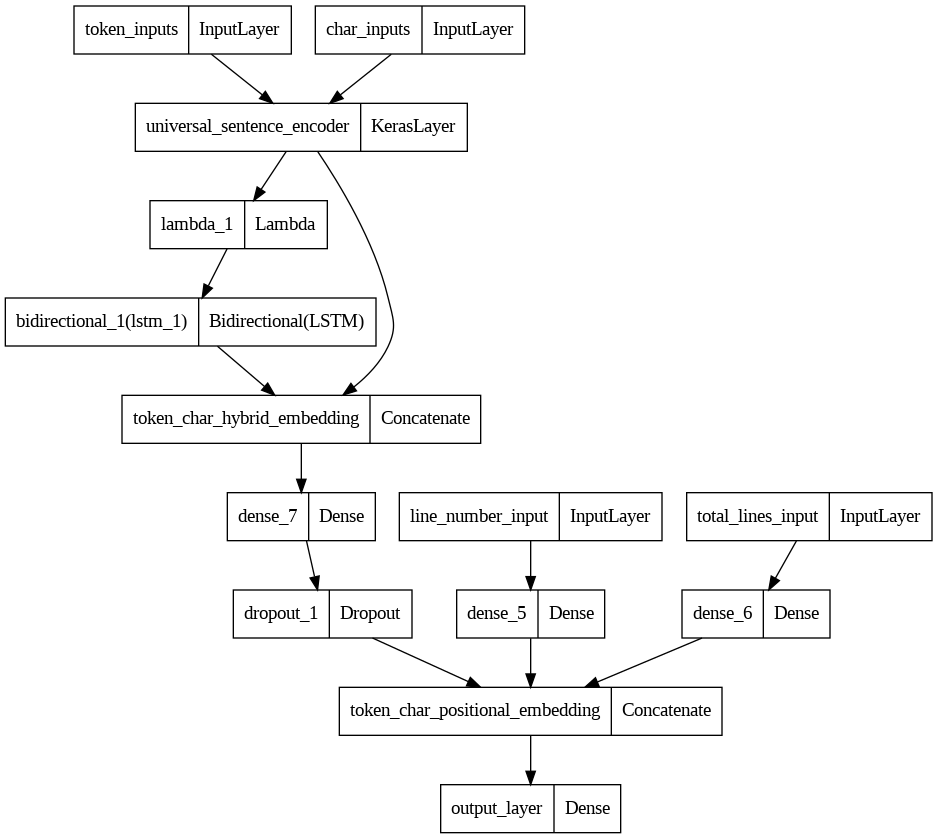

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compiling the model and fitting it on the 100% of the data for 50 epochs!

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['accuracy'])

history = model_5.fit(train_pos_char_token_dataset ,
                      epochs = 50 ,
                      validation_data = val_pos_char_token_dataset  ,
                      callbacks = [early_stopping , model_checkpoint_callback ,
                                   reduce_lr])

Epoch 1/50
5627/5627 [==============================] - 224s 38ms/step - loss: 0.9688 - accuracy: 0.8154 - val_loss: 0.9241 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 2/50
5627/5627 [==============================] - 194s 35ms/step - loss: 0.9304 - accuracy: 0.8442 - val_loss: 0.9159 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 3/50
5627/5627 [==============================] - 228s 40ms/step - loss: 0.9226 - accuracy: 0.8503 - val_loss: 0.9122 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 4/50
5627/5627 [==============================] - 186s 33ms/step - loss: 0.9172 - accuracy: 0.8548 - val_loss: 0.9071 - val_accuracy: 0.8572 - lr: 0.0010
Epoch 4: early stopping


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-05-06 13:41:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-05-06 13:41:23 (12.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results, plot_loss_curves

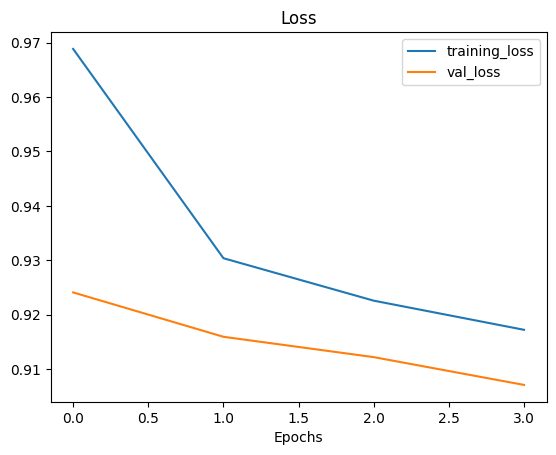

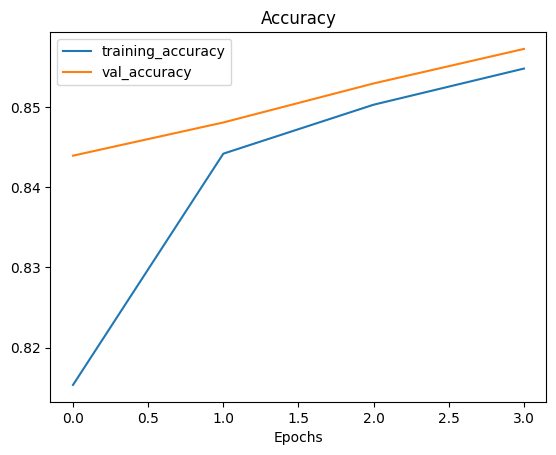

In [ ]:
plot_loss_curves(history)

In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(test_pos_char_token_dataset, verbose=1)
model_5_pred_probs

942/942 [==============================] - 24s 26ms/step


array([[0.35788524, 0.08702009, 0.03310545, 0.37510318, 0.146886  ],
       [0.2974962 , 0.0729872 , 0.25908846, 0.3043133 , 0.06611478],
       [0.03854342, 0.01624931, 0.8796876 , 0.04331378, 0.02220579],
       ...,
       [0.04390628, 0.12194586, 0.0261266 , 0.04254499, 0.7654763 ],
       [0.04826312, 0.12318889, 0.01978745, 0.03465306, 0.77410746],
       [0.04982951, 0.7000154 , 0.09534308, 0.03814119, 0.11667082]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_predictions(y_true, y_pred, classes=None,
                               figsize=(10, 8), text_size=12,
                               norm=True, savefig=False):
    """
    Draw confusion matrix + print classification report.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes is not None else np.arange(n_classes)
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(n_classes), range(n_classes)):
        if norm:
            text = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"
        else:
            text = f"{cm[i, j]}"
        ax.text(j, i, text,
                ha="center", va="center",
                color="white" if cm[i, j] > threshold else "black",
                fontsize=text_size)

    if savefig:
        fig.savefig("confusion_matrix.png")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.73      0.81      0.77      3621
 CONCLUSIONS       0.90      0.83      0.86      4571
     METHODS       0.89      0.90      0.89      9897
   OBJECTIVE       0.79      0.50      0.62      2333
     RESULTS       0.85      0.91      0.88      9713

    accuracy                           0.85     30135
   macro avg       0.83      0.79      0.80     30135
weighted avg       0.85      0.85      0.85     30135



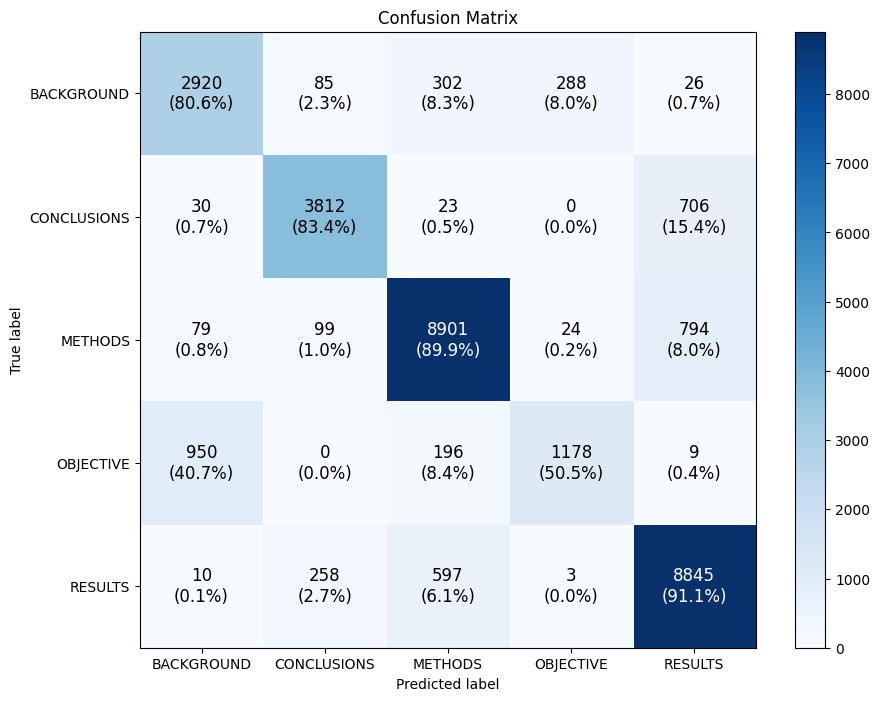

In [ ]:
evaluate_model_predictions(
    y_true=test_labels_encoded,
    y_pred=model_5_preds,
    classes=class_names,
    figsize=(10, 8),
    text_size=12,
    norm=True
)

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.13688402190145,
 'precision': 0.8513922414626678,
 'recall': 0.8513688402190145,
 'f1': 0.8482567058942205}

In [ ]:
import shutil
import os

# 目标备份文件夹
backup_folder = '/content/drive/My Drive/ColabBackup'
os.makedirs(backup_folder, exist_ok=True)

In [ ]:
# 保存完整模型（结构 + 权重 + 优化器状态）
model_5.save(backup_folder)

print(f"Model saved to: {backup_folder}")

Model saved to: /content/drive/My Drive/ColabBackup


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization

# 从 Drive 加载模型
loaded_model_5 = tf.keras.models.load_model(
    backup_folder,
    custom_objects={
        "TextVectorization": TextVectorization,
        "KerasLayer": hub.KerasLayer
    }
)

print("Model loaded successfully！")
loaded_model_5.summary()

Model loaded successfully！
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]',        
  (KerasLayer)                                            24         'char_inputs[0][0]']         
                                                                                                  
 lambda_1 (Lambda)           (None, 1, 512)               0      

In [ ]:
import tensorflow as tf

def make_predictions_with_model(model, dataset, return_probs=False, verbose=1):
    """
    Runs inference on a dataset using the given model and returns predicted class indices.

    Args:
    ------
    model : tf.keras.Model
        Trained model for prediction.
    dataset : tf.data.Dataset or tuple
        Dataset to predict on (e.g., test_pos_char_token_dataset).
    return_probs : bool (default=False)
        If True, also return the raw prediction probabilities.
    verbose : int (default=1)
        Verbosity level for model.predict().

    Returns:
    --------
    preds : tf.Tensor
        Predicted class indices (e.g., from argmax over softmax outputs).
    probs : np.ndarray (optional)
        Raw prediction probabilities (only if return_probs=True).
    """
    pred_probs = model.predict(dataset, verbose=verbose)
    pred_classes = tf.argmax(pred_probs, axis=1)

    if return_probs:
        return pred_classes, pred_probs
    else:
        return pred_classes

In [ ]:
# 如果你想同时获得预测概率
model_5_preds, model_5_pred_pr= make_predictions_with_model(
    loaded_model_5,
    test_pos_char_token_dataset,
    return_probs=True
)

942/942 [==============================] - 33s 34ms/step


In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.13688402190145,
 'precision': 0.8513922414626678,
 'recall': 0.8513688402190145,
 'f1': 0.8482567058942205}

### 5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
```
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LA
```

From the derived raw abstract, for each abstract we will need to:
- Split it into sentence (lines)
- Split it into characters
- Find the number of each line
- Find the total number of lines.


We will use spacy to extract the abstract informations

In [ ]:
# Getting the example abstract to test our function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json


--2025-05-06 14:04:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2025-05-06 14:04:54 (96.6 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [ ]:
# Using json to load in our abstract sample
import json
with open('skimlit_example_abstracts.json' , 'r') as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# How does our abstracts look in a DataFrame?
pd.DataFrame(example_abstracts)

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Making a function that takes in a dictionary of abstracts and information and prints out the predicted class with the line

```
Predicted Class : Sequence
Predicted Class : Sequence
Predicted Class : Sequence
Predicted Class : Sequence

```

In [ ]:
import spacy
from spacy.lang.en import English
import tensorflow as tf

def visualize_pred_sequence_labels(abstract_dict, model, label_encoder):
    """
    Visualize model predictions on a single abstract.

    Args:
    ------
    abstract_dict : list of dict
        [{'abstract': 'This RCT examined ...', 'details': ..., 'source': ...}]
    model : tf.keras.Model
        Trained tribrid model
    label_encoder : fitted LabelEncoder
        Encoder used to transform labels to integers

    Returns:
    --------
    Prints predicted labels line-by-line with the corresponding sentence.
    """

    # Make sure input is valid
    assert isinstance(abstract_dict, list) and len(abstract_dict) > 0 and 'abstract' in abstract_dict[0]

    # Load spaCy English tokenizer and add sentencizer
    nlp = English()
    nlp.add_pipe("sentencizer")

    # Parse sentences
    doc = nlp(abstract_dict[0]['abstract'])
    abstract_lines = [str(sent).strip() for sent in list(doc.sents) if sent.text.strip() != ""]

    # Total lines = N - 1 (zero-indexed)
    total_lines_in_sample = len(abstract_lines)
    sample_lines = []

    for i, line in enumerate(abstract_lines):
        sample_lines.append({
            'text': line,
            'line_number': i,
            'total_lines': total_lines_in_sample - 1
        })

    # One-hot encode line number and total lines
    abstract_line_numbers = [line['line_number'] for line in sample_lines]
    abstract_total_lines = [line['total_lines'] for line in sample_lines]
    abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers, depth=15)
    abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines, depth=20)

    # 字符拆分（注意：你需要自定义这个函数）
    abstract_chars = [split_chars(line['text']) for line in sample_lines]
    abstract_sentences = [line['text'] for line in sample_lines]

    # 模型预测
    abstract_pred_probs = model.predict(x=(
        abstract_line_numbers_one_hot,
        abstract_total_lines_one_hot,
        tf.constant(abstract_sentences),
        tf.constant(abstract_chars)
    ))

    abstract_preds = tf.argmax(abstract_pred_probs, axis=1)
    abstract_pred_classes = label_encoder.inverse_transform(abstract_preds.numpy())

    # 打印每一句话和其对应的预测标签
    for i, line in enumerate(abstract_sentences):
        print(f"{abstract_pred_classes[i]}: {line}\n")


In [ ]:
visualize_pred_sequence_labels(example_abstracts , model_5 , label_encoder)

1/1 [==============================] - 1s 1s/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS: Participants were randomly assigned to treatment or wait-list conditions.

METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and fav